# Deep model for *rate* variable classification

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import os
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


## Useful functions

In [0]:
def load_data():
    train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/Train.csv", sep=";", error_bad_lines=False)
    test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/TestX.csv", sep=";", error_bad_lines=False)
    return train, test



def prepare_inputs(X_train, X_val, X_test):
    X_train_enc, X_val_enc, X_test_enc = list(), list(), list()
    # label encode each column

    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_val[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        val_enc = le.transform(X_val[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_val_enc.append(val_enc)
        X_test_enc.append(test_enc)
        
    return X_train_enc, X_val_enc, X_test_enc


def prepare_outputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc


def train_val_split(train_data, rate=0.9, unique=True, seed=17):
    if unique == True:
        unique_opinions = pd.unique(train_data["opinion"].values)
        train = train_data.loc[train_data["opinion"].isin(unique_opinions[:int(unique_opinions.shape[0]*rate)])]
        val = train_data.loc[train_data["opinion"].isin(unique_opinions[int(unique_opinions.shape[0]*rate):])]
        return train, val
    else:
        train, val = train_test_split(train_data, test_size=(1-rate), random_state=seed)
        return train, val 

def decode_sentence(text, reverse_word_index):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


def plot_history(history, metric="rate_"):
    # Plot training & validation accuracy values
    plt.plot(history.history[metric + 'accuracy'])
    plt.plot(history.history['val_' + metric + 'accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history[metric + 'loss'])
    plt.plot(history.history['val_' + metric + 'loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## code

#### define static vars

In [0]:
VOCAB_SIZE = 5000
EMB_DIM = 64
MAX_LEN = 400
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'
OOV_TOK = '<OOV>'

#### load and preprocess dataset

In [0]:
train, test = load_data()
train, test = train.dropna(), test.dropna()
# train, val = train_val_split(train, rate=0.9)
train, val = train_val_split(train, rate=0.9, unique=False)
train, val = train.reset_index(), val.reset_index()


train_posts, val_posts, test_posts = train['opinion'], val['opinion'], test['opinion']
X_train_enc, X_val_enc, X_test_enc = prepare_inputs(train[["name", "condition"]].values, val[["name", "condition"]].values, test[["name", "condition"]].values)
# train_labels, val_labels = train['rate1'], val['rate1']
train_labels, val_labels= prepare_outputs(train[['rate', 'rate1']].values, val[['rate', 'rate1']].values)
# train_labels, val_labels = train_labels[0], val_labels[0]
print("train shape: {}, val shape: {}".format(train.shape, val.shape))

train shape: (134244, 6), val shape: (14917, 6)


In [0]:
print("train encoded", X_train_enc, np.max(X_train_enc[1]))
print("test encoded", X_test_enc, np.max(X_test_enc[1]))

train encoded [array([1854,   48,  196, ..., 1129, 3473, 1978]), array([268, 155, 449, ..., 882,  76, 179])] 906
test encoded [array([3447, 1642,  530, ..., 3517,  225, 1082]), array([852, 171, 129, ...,  83, 157,   0])] 906


#### class weights calculate

#### fit tokenizer on words in opiniions

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(pd.concat((train_posts, val_posts), axis=0))
word_index = tokenizer.word_index
print("sample tokens: ", dict(list(word_index.items())[0:100]))
print("sample tokens: ", dict(list(word_index.items())[4900:5000]))

sample tokens:  {'<OOV>': 1, 'i': 2, 'and': 3, 'the': 4, 'to': 5, 'it': 6, 'my': 7, 'a': 8, '039': 9, 'for': 10, 'was': 11, 'have': 12, 'of': 13, 'on': 14, 'this': 15, 'in': 16, 'but': 17, 'me': 18, 'had': 19, 'is': 20, 'that': 21, 'with': 22, 't': 23, 'not': 24, 'so': 25, 'been': 26, 'at': 27, 'after': 28, 'no': 29, 'day': 30, 'am': 31, 'as': 32, 'about': 33, 'm': 34, 'now': 35, 'side': 36, 'taking': 37, 'all': 38, 'has': 39, 've': 40, 's': 41, 'years': 42, 'pain': 43, 'effects': 44, 'first': 45, 'take': 46, 'you': 47, 'months': 48, 'only': 49, 'started': 50, '2': 51, 'like': 52, 'get': 53, 'up': 54, 'be': 55, 'days': 56, 'just': 57, 'very': 58, 'time': 59, 'out': 60, 'from': 61, 'or': 62, 'when': 63, '3': 64, 'can': 65, 'feel': 66, 'if': 67, 'would': 68, 'because': 69, 'back': 70, 'pill': 71, 'more': 72, 'one': 73, 'weeks': 74, 'are': 75, 'week': 76, 'doctor': 77, 'also': 78, 'took': 79, 'period': 80, 'medication': 81, 'weight': 82, 'before': 83, 'then': 84, 'got': 85, 'will': 86, 'd

#### tokenize words in opinions in train and val dataset


In [0]:
train_sequences = tokenizer.texts_to_sequences(train_posts)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_LEN,
                                                             padding=PAD_TYPE, truncating=TRUNC_TYPE)
validation_sequences = tokenizer.texts_to_sequences(val_posts)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)

test_sequences = tokenizer.texts_to_sequences(test_posts)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)
print("sample tokenized sentence: ", train_sequences[10])
print("sample tokenized sentence: ", test_sequences[10])

sample tokenized sentence:  [2, 12, 26, 37, 2827, 3980, 10, 33, 2323, 48, 63, 2, 411, 14, 4, 141, 2, 12, 144, 62, 29, 70, 43, 67, 2, 203, 10, 123, 112, 56, 4, 43, 741, 70, 17, 219, 2, 283, 131, 4, 43, 20, 238, 16, 73, 62, 112, 56, 6, 39, 190, 18, 1397]
sample tokenized sentence:  [7, 1159, 20, 427, 130, 51, 42, 199, 3, 39, 26, 998, 16, 8, 3475, 503, 10, 4, 313, 138, 42, 145, 122, 228, 569, 157, 98, 24, 101, 143, 4517, 13, 154, 282, 224, 400, 636, 3346, 27, 4, 3778, 13, 4, 567, 4, 3475, 503, 160, 400, 14, 246, 150, 744, 3, 400, 171, 791, 224, 154, 421, 22, 29, 36, 44, 228, 11, 1, 131, 3, 11, 1808, 5, 46, 92, 32, 6, 326, 400, 270, 5, 213, 67, 228, 155, 596, 14, 8, 438, 148, 33, 8, 88, 132, 110, 982, 400, 148, 5, 138, 150, 3, 4, 98, 1002, 316, 400, 148, 11, 1293, 70, 54, 5, 246, 150, 3, 260, 75, 1, 8, 1339, 5, 400, 615, 561, 612]


#### check tokenization

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original: ", train_posts[0])
print('---')
print("Tokenized then decoded: ", decode_sentence(train_padded[0], reverse_word_index))

Original:  "I&#039;ve been on lex for almost a month and so far my side effects have been minimal. The first week, although I didn&#039;t have anxiety problems, it seemed to spark a few anxiety episodes. Nothing major. I started with 10mg and today is my first day of 20mgs. I&#039;m a little worried about side effects. I&#039;m still having a problem wanting to get out of bed. I just feel like I have no energy to do anything and I hate this feeling hence the increase to 20mgs. I&#039;m going to stick with it because although I&#039;m still struggling with the lack of energy, is helped at least put a few smiles back on my face here and there. All I know is I want to get better, I have to get better! 
Good luck everyone I&#039;ll check back in 3 or 4 wks &amp; give a complete update."
---
Tokenized then decoded:  i 039 ve been on <OOV> for almost a month and so far my side effects have been minimal the first week although i didn 039 t have anxiety problems it seemed to <OOV> a few anxiet

#### Model 

In [0]:
#%% define recurrent part of model
in1 = tf.keras.layers.Input(shape=(400,))
h1 = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM)(in1)
# h1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM, return_sequences=True))(h1)
h12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM, return_sequences=True))(h1)
h12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM))(h12)
h13 = tf.keras.layers.Dense(EMB_DIM, activation='relu')(h12)

#%% define other parts of models (input and dense layers for condition and drug)
in_layers = list()
em_layers = list()
d_layers = list()
for i in range(len(X_train_enc)):
    # TODO: check if it is ok to know that there will be new drugs/conditions for embedding layer
    # calculate the number of unique inputs
    n_labels = len(np.unique(np.concatenate((X_train_enc[i], X_val_enc[i], X_test_enc[i]), axis=0)))
    # define input layer
    in_layer = tf.keras.layers.Input(shape=(1,))
    # define embedding layer
    em_layer = tf.keras.layers.Embedding(n_labels+1, 10,  input_length=1)(in_layer)
    # dense for concat
    dense_layer = tf.keras.layers.Flatten()(em_layer)
    # store layers
    in_layers.append(in_layer)
    em_layers.append(em_layer)
    d_layers.append(dense_layer)

d_layers.append(h13)
in_layers.append(in1)

#%% define final model
merge = tf.keras.layers.concatenate(d_layers)
dense = tf.keras.layers.Dense(80, activation='relu', kernel_initializer='he_normal')(merge)
dense = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dropout(0.3)(dense)
dense = tf.keras.layers.Dense(40, activation='relu', kernel_initializer='he_normal')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal')(dense)
dense = tf.keras.layers.Dropout(0.1)(dense)
dense = tf.keras.layers.BatchNormalization()(dense)
output = tf.keras.layers.Dense(10, activation='softmax', name="rate")(dense)
output2 = tf.keras.layers.Dense(3, activation='softmax', name="rate1")(dense)
output3 = tf.keras.layers.Dense(1, activation='relu', name="rate_reg")(dense)
model = tf.keras.models.Model(inputs=in_layers, outputs=[output, output2, output3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

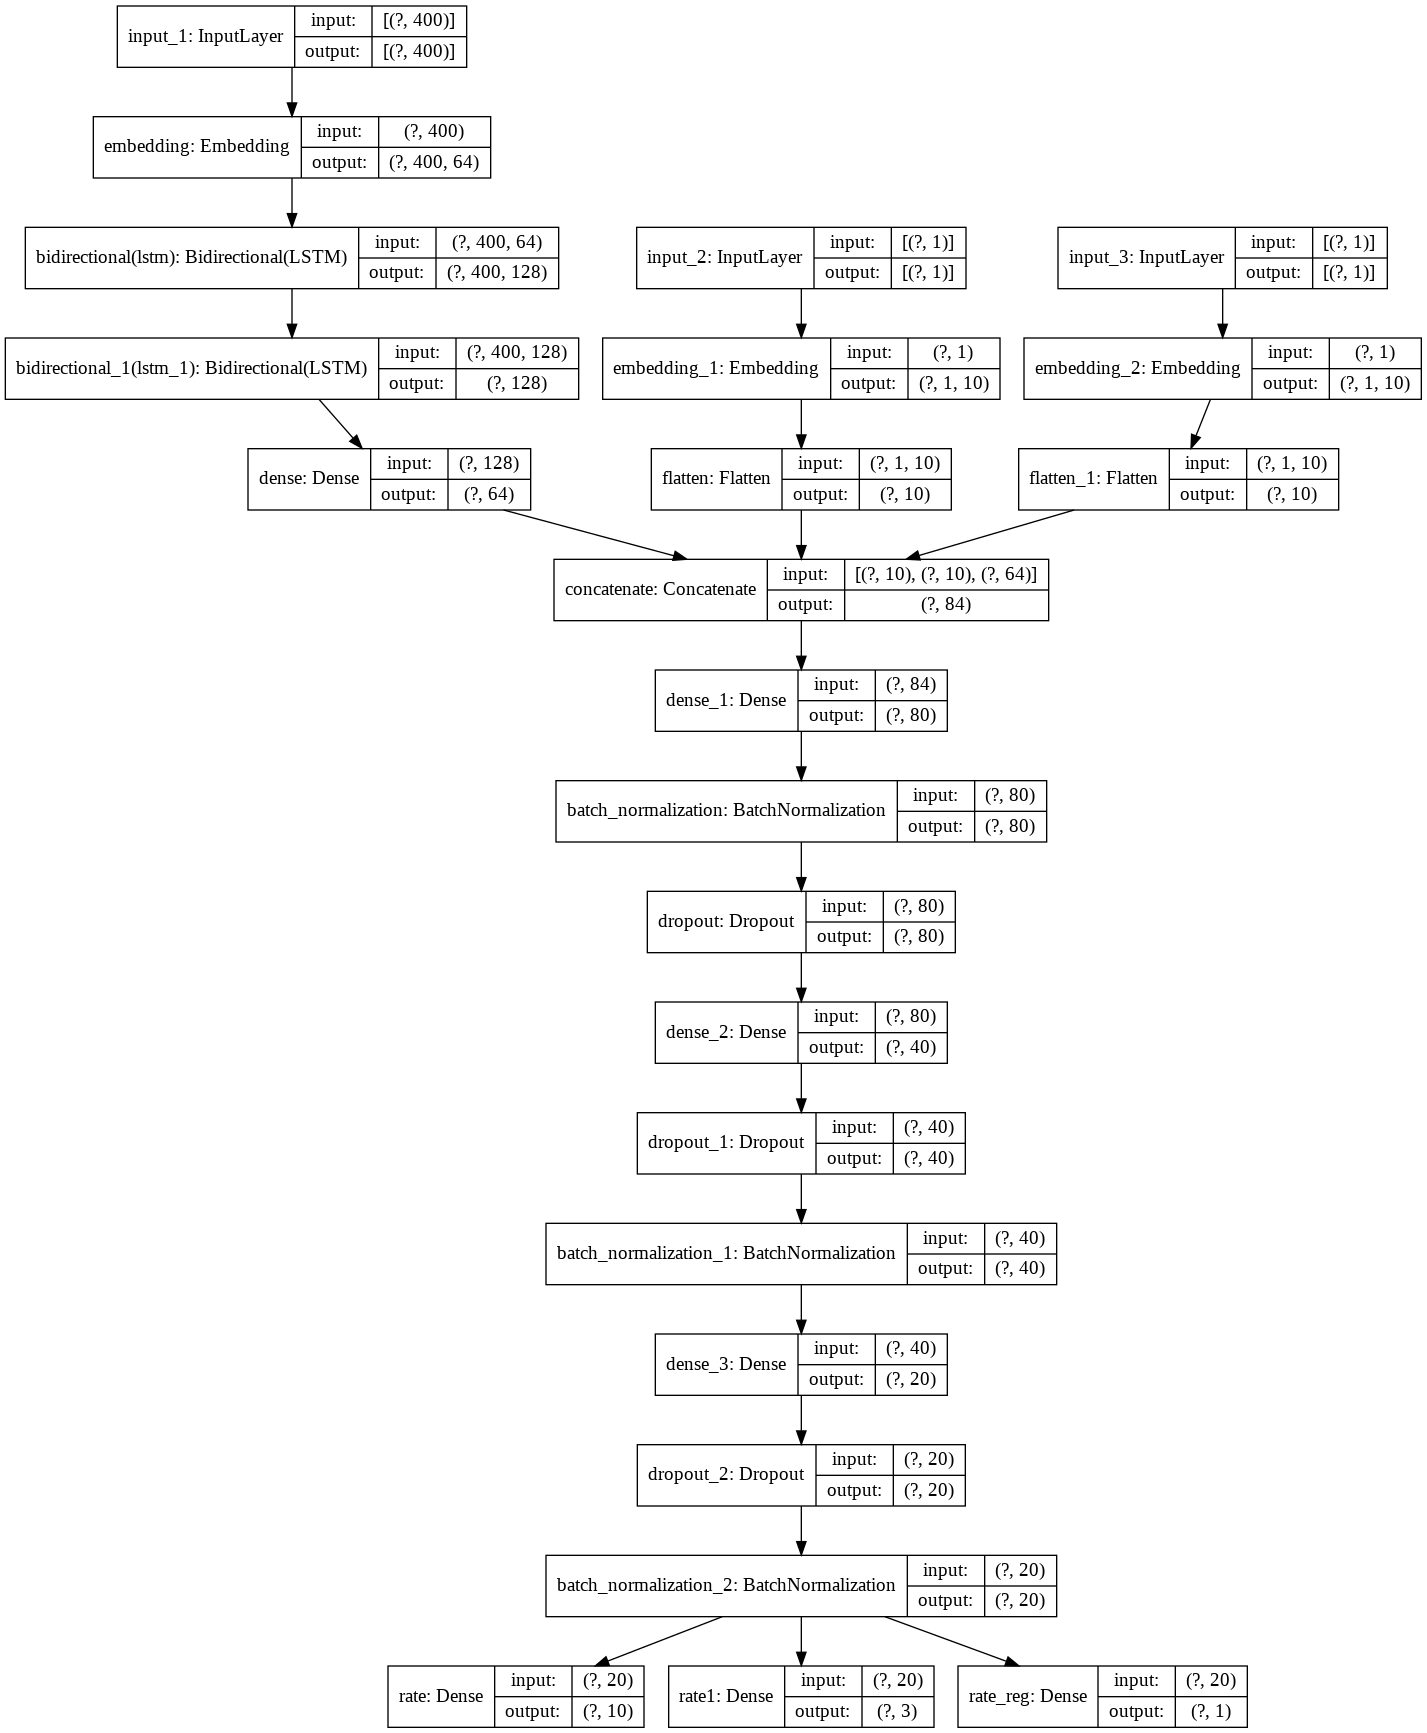

In [0]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

#### conversion to one hot variables

In [0]:
# convert integers to dummy variables (i.e. one hot encoded)
train_labels_one_hot = []
val_labels_one_hot = []


train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[0]))
train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[1]))

val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[0]))
val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[1]))

print(f"shape: {len(train_labels_one_hot)} one hot encoded: {train_labels_one_hot}")

shape: 2 one hot encoded: [array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)]


In [0]:
train_labels[0]

array([2, 9, 9, ..., 6, 9, 9])

#### callbacks

In [0]:
run_path = "/content/drive/My Drive/Colab Notebooks/zmum/models/three_easy"
earlyStopping = EarlyStopping(monitor='rate_accuracy', patience=10, verbose=0)
mcp_save = ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{val_rate_accuracy:03f}-{val_rate1_accuracy:03f}.h5'),
                           save_best_only=True, monitor='rate_accuracy', patience=7)
reduce_lr_loss = ReduceLROnPlateau(monitor='rate_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]


#### model training and history

In [0]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/zmum/models/three_easy/model-008-0.527385-0.830998.h5")
model.compile(
    optimizer='adam',
    loss={
        "rate": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate1": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate_reg": tf.keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[1.0, 0.2, 1],
    metrics=[['accuracy'], ['accuracy'], ['mae']]
)

In [0]:
num_epochs = 100

history = model.fit(
    {"input_1": train_padded, "input_2": X_train_enc[0], "input_3": X_train_enc[1]},
    {"rate": train_labels_one_hot[0], "rate1": train_labels_one_hot[1], "rate_reg": train_labels[0]},
    epochs=num_epochs,
    batch_size=100,
    callbacks=callbacks,
    validation_data=({"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]},
                    {"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]})
)

Epoch 1/100
1343/1343 [==============================] - 371s 277ms/step - loss: 2.4060 - rate_loss: 1.7586 - rate1_loss: 0.6257 - rate_reg_loss: 0.5223 - rate_accuracy: 0.7028 - rate1_accuracy: 0.9256 - rate_reg_mae: 0.5223 - val_loss: 3.0706 - val_rate_loss: 1.9380 - val_rate1_loss: 0.7231 - val_rate_reg_loss: 0.9880 - val_rate_accuracy: 0.5224 - val_rate1_accuracy: 0.8270 - val_rate_reg_mae: 0.9880 - lr: 0.0010
Epoch 2/100
1343/1343 [==============================] - 370s 276ms/step - loss: 2.3976 - rate_loss: 1.7559 - rate1_loss: 0.6244 - rate_reg_loss: 0.5168 - rate_accuracy: 0.7053 - rate1_accuracy: 0.9269 - rate_reg_mae: 0.5168 - val_loss: 3.0825 - val_rate_loss: 1.9366 - val_rate1_loss: 0.7222 - val_rate_reg_loss: 1.0014 - val_rate_accuracy: 0.5237 - val_rate1_accuracy: 0.8280 - val_rate_reg_mae: 1.0014 - lr: 0.0010
Epoch 3/100
1343/1343 [==============================] - 367s 273ms/step - loss: 2.4137 - rate_loss: 1.7623 - rate1_loss: 0.6255 - rate_reg_loss: 0.5263 - rate_accu

In [0]:
plot_history(history)


In [0]:
# predictions = model.predict([X_val_enc[0], X_val_enc[1], validation_padded])
predictions = model.predict({"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]})
predictions

[array([[9.26916752e-20, 1.72964775e-20, 5.11601334e-27, ...,
         1.03942606e-17, 8.50746492e-18, 1.00000000e+00],
        [1.25024314e-07, 1.17872101e-10, 4.63109154e-06, ...,
         6.61908617e-09, 2.20108483e-08, 1.09120595e-10],
        [8.57742372e-18, 6.18621777e-12, 1.74853587e-14, ...,
         9.98295724e-01, 7.58930400e-05, 5.01170927e-09],
        ...,
        [8.57742372e-18, 6.18621777e-12, 1.74853587e-14, ...,
         9.98295724e-01, 7.58930400e-05, 5.01170927e-09],
        [5.67139262e-21, 1.00942247e-12, 5.79463263e-18, ...,
         1.08557674e-06, 9.99838114e-01, 1.60810858e-04],
        [5.20511398e-21, 8.01156179e-13, 3.94975558e-18, ...,
         4.07272466e-07, 9.99841452e-01, 1.58212439e-04]], dtype=float32),
 array([[1.0000000e+00, 2.4171989e-17, 5.4615600e-12],
        [1.1924392e-08, 2.3391737e-04, 9.9976605e-01],
        [9.9551684e-01, 1.4639985e-10, 4.4831294e-03],
        ...,
        [9.9551684e-01, 1.4639985e-10, 4.4831289e-03],
        [1.000000

In [0]:
metrics = model.evaluate(x={"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]},
                    y={"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]})
metrics

### Rate confusion matrix

#### Classification

Confusion matrix, without normalization
[[1538    0  129    0  113    0   25   37   20   63]
 [ 389    0  118    0   65    0   18   24    9   19]
 [ 164    0  209    0  116    0   30   35   14   17]
 [  80    0  101    0  194    0   38   36   17   18]
 [  62    0   38    0  377    0   88   73   38   44]
 [  37    0   20    0  170    0  160   96   45   52]
 [  20    0   20    0   99    0  307  225  151   89]
 [  30    0   25    0   82    0  138  678  435  369]
 [  37    0    4    0   57    0   82  334 1036 1015]
 [  55    0   16    0   58    0   68  241  588 3722]]


0.5273848629080914

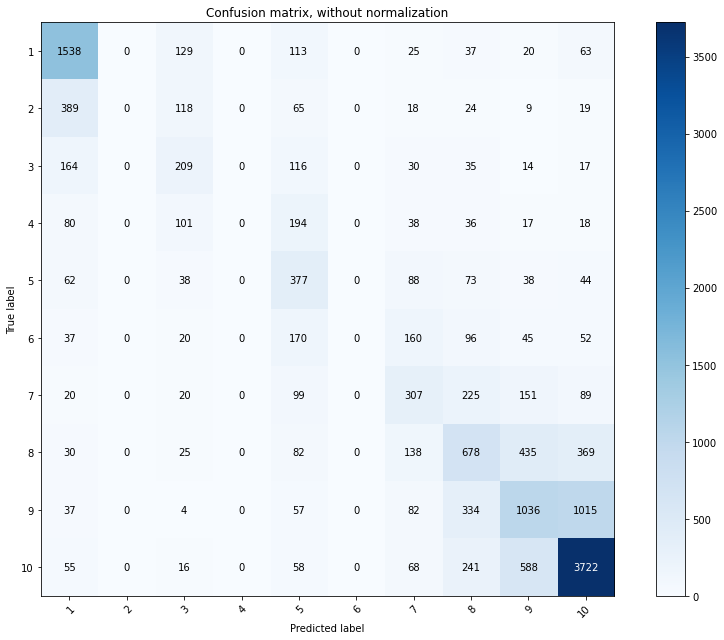

In [0]:
y_pred = np.argmax(predictions[0], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Rounding to nearest int

Confusion matrix, without normalization
[[1518   25   89   45   77   28   28   40   22   53]
 [ 379   17   91   29   46   13   14   25    9   19]
 [ 157   12  136   83   83   26   21   37   18   12]
 [  74   10   47   70  153   23   34   38   20   15]
 [  61    3   18   35  274  106   69   72   40   42]
 [  35    0   12   12  110   79  139  101   50   42]
 [  17    1   12   12   69   48  278  235  154   85]
 [  24    4   21    6   55   32  133  684  447  351]
 [  29    5    4    7   33   24   75  341 1066  981]
 [  47    9    7    7   48   19   60  247  623 3681]]


0.5230944559898103

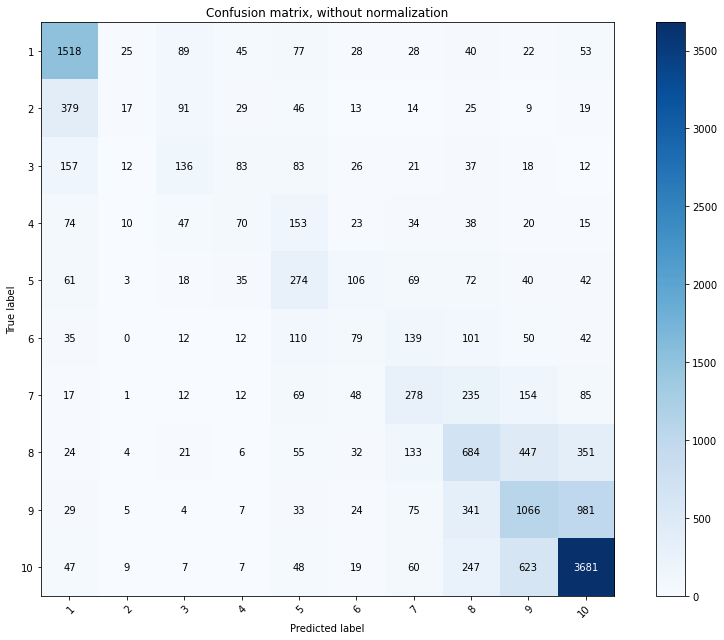

In [0]:
# y_pred = predictions[2].astype('int') 
y_pred = [round(elem[0]) for elem in predictions[2]]
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Float projection to int

Confusion matrix, without normalization
[[1532   32  101   27   82   14   26   36   35   40]
 [ 387   25   94   20   44   11    9   24   13   15]
 [ 164   30  179   45   67   16   19   37   19    9]
 [  75   20   85   59  131   14   32   36   21   11]
 [  61    9   32   53  311   54   49   74   38   39]
 [  35    2   18   21  140   67  112   99   51   35]
 [  18    3   17    9   84   68  252  244  142   74]
 [  26    2   26    7   70   29  137  710  443  307]
 [  31    4    4   17   37   19   73  367 1124  889]
 [  49    9   11    9   48   26   57  258  777 3504]]


0.5204129516658845

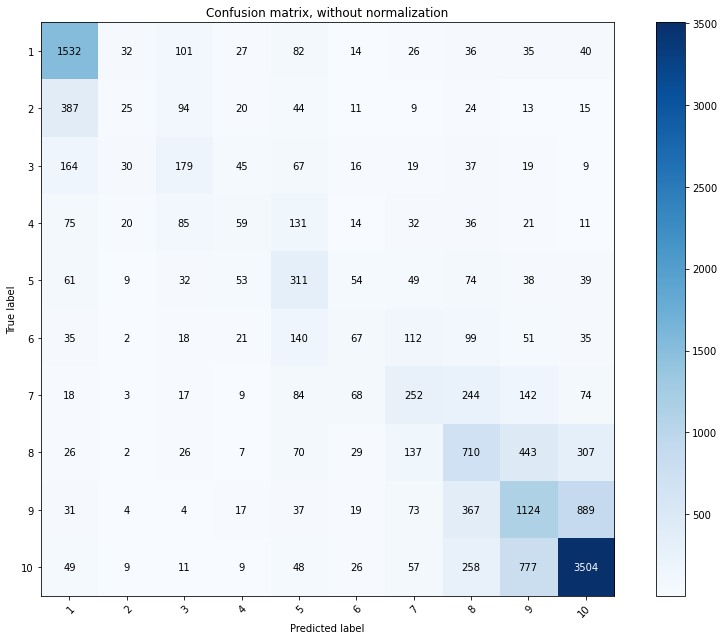

In [0]:
y_pred = predictions[2].astype('int') 
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)

### Rate1 confusion matrix

#### Classification


In [0]:
y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


Confusion matrix, without normalization
[[8414  166  490]
 [ 234 2563  355]
 [ 885  391 1419]]


0.8309981899845813

#### Based on rate


Confusion matrix, without normalization
[[8418  167  485]
 [ 238 2547  367]
 [ 884  378 1433]]


0.8311322652007777

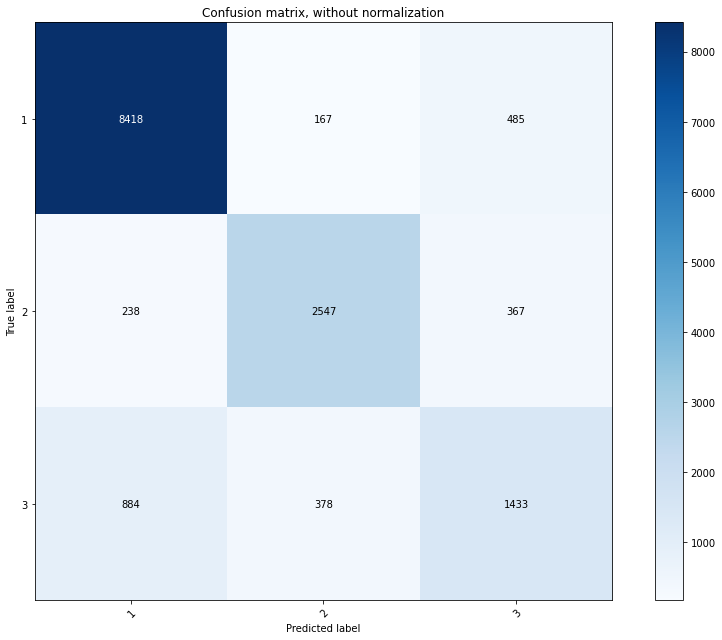

In [0]:
rate = np.argmax(predictions[0], axis=1)
rate+=1

y_pred = []
for i, elem in enumerate(rate):
    if elem <= 3:
        y_pred.append(1)
    elif 3 < elem < 8:
        y_pred.append(2)
    else:
        y_pred.append(0)

# y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


# Test predictions

In [0]:
pred_test = model.predict({"input_1": test_padded, "input_2": X_test_enc[0], "input_3": X_test_enc[1]})

In [0]:
pred_test

[array([[1.61e-21, 5.34e-21, 3.64e-28, ..., 1.29e-17, 1.17e-16, 1.00e+00],
        [8.58e-18, 6.19e-12, 1.75e-14, ..., 9.98e-01, 7.59e-05, 5.01e-09],
        [1.26e-17, 1.91e-16, 1.14e-22, ..., 7.18e-13, 5.11e-11, 1.00e+00],
        ...,
        [3.88e-21, 7.75e-13, 3.67e-18, ..., 6.88e-07, 1.00e+00, 1.73e-04],
        [2.69e-20, 1.21e-20, 1.99e-27, ..., 1.18e-17, 2.50e-17, 1.00e+00],
        [1.83e-20, 1.19e-20, 1.54e-27, ..., 1.29e-17, 4.68e-17, 1.00e+00]],
       dtype=float32), array([[1.00e+00, 1.56e-19, 5.69e-14],
        [9.96e-01, 1.46e-10, 4.48e-03],
        [1.00e+00, 5.27e-16, 1.99e-10],
        ...,
        [1.00e+00, 1.58e-17, 1.37e-09],
        [1.00e+00, 4.96e-18, 1.14e-12],
        [1.00e+00, 3.10e-18, 6.93e-13]], dtype=float32), array([[9.02],
        [7.07],
        [8.7 ],
        ...,
        [8.08],
        [9.01],
        [9.01]], dtype=float32)]

In [0]:
rate = np.argmax(pred_test[0], axis=1)
rate+=1
rate1_tmp = np.argmax(pred_test[1], axis=1)
rate1 = []
for i, elem in enumerate(rate):
    if elem <= 3:
        rate1.append("low")
    elif 3 < elem < 8:
        rate1.append("medium")
    else:
        rate1.append("high")
rate1 = np.asanyarray(rate1)
df = pd.DataFrame(data = np.concatenate([np.expand_dims(rate, axis=1), np.expand_dims(rate1, axis=1)], axis=1), columns=["rate", "rate1"])
df.head(100)
df.to_csv("/content/drive/My Drive/Colab Notebooks/zmum/models/results_easy.csv")